<a href="https://colab.research.google.com/github/jaya-shankar/education-impact/blob/master/GDP_percaptia_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf education-impact

In [1]:
!git clone https://github.com/jaya-shankar/education-impact.git


Cloning into 'education-impact'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (361/361), done.
remote: Compressing objects: 100% (303/303), done.
remote: Total 361 (delta 181), reused 175 (delta 55), pack-reused 0
Receiving objects: 100% (361/361), 3.47 MiB | 4.32 MiB/s, done.
Resolving deltas: 100% (181/181), done.


In [2]:
!pip install tensorflow_decision_forests
!pip install wurlitzer
!pip install seaborn

     |████████████████████████████████| 17.1 MB 429 kB/s 


In [3]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from wurlitzer import sys_pipes

In [4]:
#@title Default title text
root = "education-impact/datasets/" 
datasets_path = {
                    "infant_mortality"                :  root+ "Infant_Mortality_Rate.csv",
                    "child_mortality"                 :  root+ "child_mortality_0_5_year_olds_dying_per_1000_born.csv",
                    "children_per_woman"              :  root+ "children_per_woman_total_fertility.csv",
                    "co2_emissions"                   :  root+ "co2_emissions_tonnes_per_person.csv",
                    "population"                      :  root+ "converted_pop.csv",
                    "population_density"              :  root+ "population_per_area.csv",
                    "gdp_growth"                      :  root+ "gdp_per_capita_yearly_growth.csv",
                    "Avg_daily_income_ppp"            :  root+ "mincpcap_cppp.csv",
                    "gdppercapita_us_infla_adjust"    :  root+ "gdppercapita_us_inflation_adjusted.csv",
                    "gini_index"                      :  root+ "gini.csv",
                    "life_expectancy"                 :  root+ "life_expectancy_years.csv",
                    "poverty_index"                   :  root+ "mincpcap_cppp.csv",
                    "people_in_poverty"               :  root+ "number_of_people_in_poverty.csv",
                    "ratio_b/g_in_primary"            :  root+ "ratio_of_girls_to_boys_in_primary_and_secondary_education_perc.csv",
                    "wcde-25--34"                     :  root+ "wcde-25--34.csv",
                    "20-24-In_Primary_OL"             :  root+ "In_Primary_OL.csv",
                    "20-24-Primary_OL"                :  root+ "Primary_OL.csv",
                    "20-24-Lower_Secondary_OL"        :  root+ "Lower_Secondary_OL.csv",
                    "20-24_female-In_Primary_OL"      :  root+ "female_In_Primary_OL.csv",
                    "20-24_female-Primary_OL"         :  root+ "female_Primary_OL.csv",
                    "20-24_female-Lower_Secondary_OL" :  root+ "female_Lower_Secondary_OL.csv"
                }

In [15]:
datasets_to_plot = [
            "life_expectancy",
            "infant_mortality",
            "child_mortality",
            "children_per_woman",
            "co2_emissions",
            "gini_index",
            "20-24-In_Primary_OL",
            "20-24-Lower_Secondary_OL",
            "population",
            "population_density",
            "20-24_female-In_Primary_OL",
            "20-24_female-Primary_OL" ,
            "20-24_female-Lower_Secondary_OL",
            "20-24-Primary_OL",
            "gdppercapita_us_infla_adjust",
            ]

output_y = "gdppercapita_us_infla_adjust"
PREDICT_FUTURE  = 10
# creating a list of all countries & years
countries   = find_common_countries(datasets_to_plot)
years       = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys        = generate_indices(countries, years)

combined_df = load_datasets_to_pd(datasets_to_plot,keys,include_output=False)

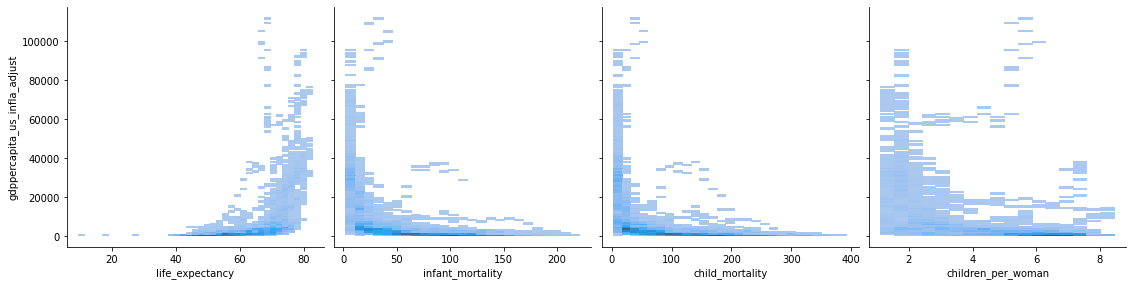

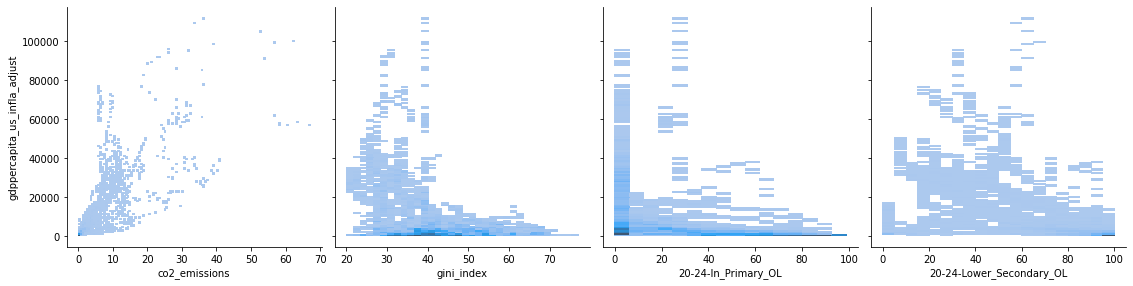

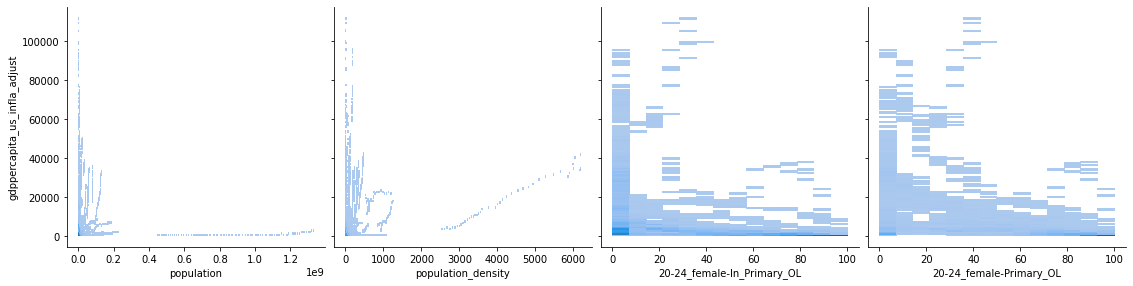

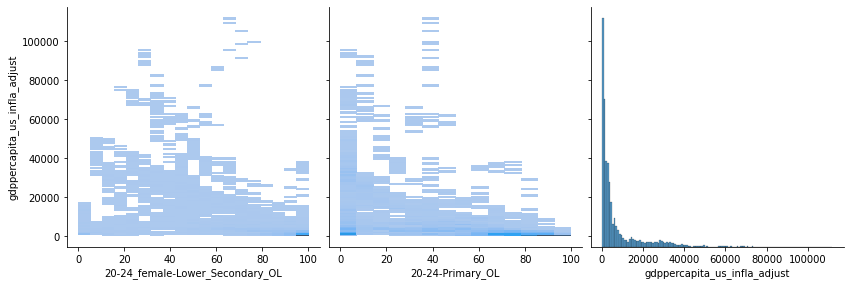

In [16]:
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,kind="hist", y_vars=[output_y], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

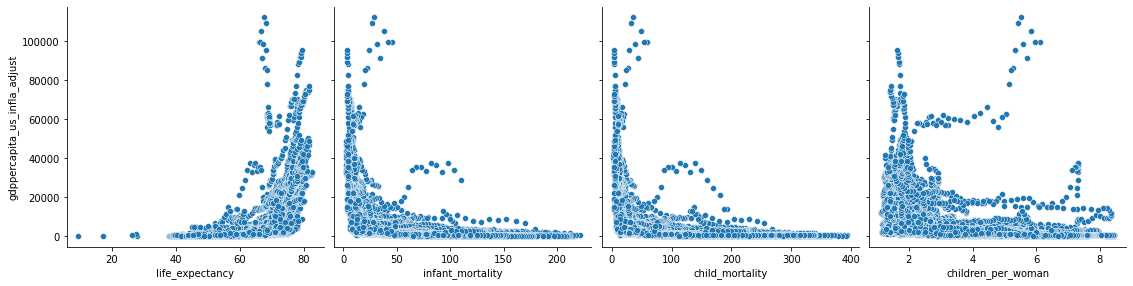

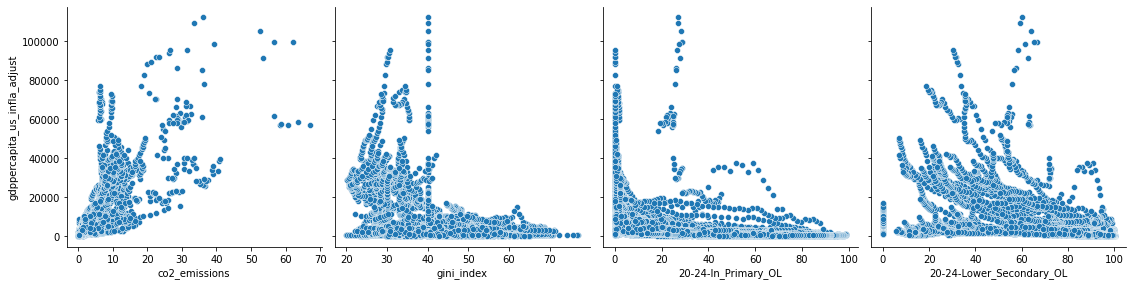

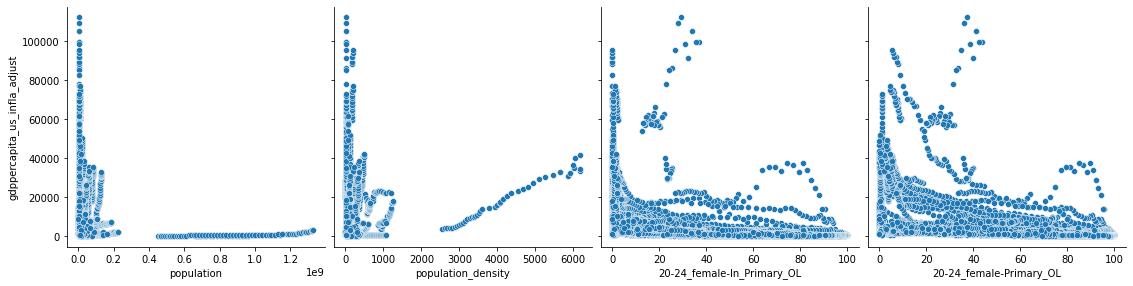

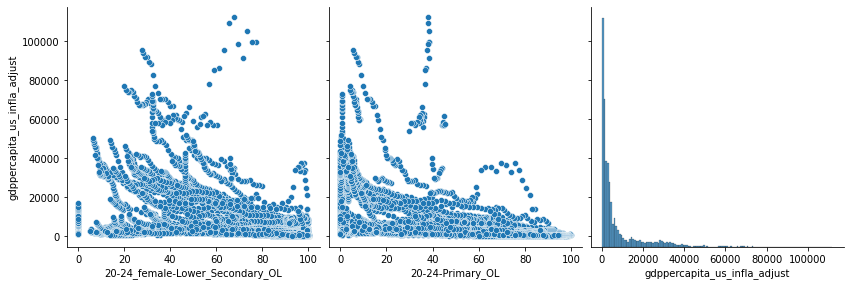

In [17]:
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,kind="scatter", y_vars=[output_y], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

In [7]:
def get_countries_count(datasets):
  for dataset in datasets:
    df = pd.read_csv(datasets_path[dataset])
    count = len(set(df.Country.unique()))
    print(f"{'Factor: ' + dataset:<40} count: {count}")


In [8]:
def find_common_countries(datasets):
  common_countries = set()
  for dataset in datasets:
    countries_list = list(pd.read_csv(datasets_path[dataset]).Country)
    countries_list = set(map(lambda x: x.lower(), countries_list))
    if common_countries == set():
      common_countries = countries_list
    else:
      common_countries = common_countries.intersection(countries_list)
  return list(common_countries)

In [9]:
def generate_indices(countries,years):
  keys=[]
  for y in years:
    for c in countries:
      keys.append((c,str(y)))
  return keys

In [10]:
def load_datasets_to_pd(datasets,keys,include_output=True):
  combined_df = pd.DataFrame(keys,columns=['country','year'])
  for dataset in datasets:
    combined_df[dataset] = [math.nan]*len(combined_df)
    df = pd.read_csv(datasets_path[dataset])
    df["Country"] = df["Country"].str.lower()
    df.set_index("Country", inplace=True)
    for e in range(len(combined_df)):
      country = combined_df.iloc[e].country
      year    = combined_df.iloc[e].year
      combined_df.at[e,dataset] = df.loc[country][year]

  if include_output:
    label = "o_"+OUTPUT
    combined_df[label] = [math.nan]*len(combined_df)
    df = pd.read_csv(datasets_path[OUTPUT])
    df["Country"] = df["Country"].str.lower()
    df.set_index("Country", inplace=True)
    for e in range(len(combined_df)):
      country = combined_df.iloc[e].country
      year    = int(combined_df.iloc[e].year)
      combined_df.at[e,label] = df.loc[country][str( year + PREDICT_FUTURE )]
    combined_df.set_index(["country","year"], inplace=True)
  return combined_df

  

In [11]:
def combine_dfs(X,y):
  label = y.columns[0]
  X[label] = y
  X.dropna(subset=[label],inplace=True)
  return X

## Main Code starts from here

In [18]:
datasets = [
            "infant_mortality",
            "life_expectancy",
            "child_mortality",
            "children_per_woman",
            "co2_emissions",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            "20-24-In_Primary_OL",
            "20-24-Primary_OL",
            "20-24-Lower_Secondary_OL",
            "population",
            "20-24_female-In_Primary_OL",
            "20-24_female-Primary_OL" ,
            "20-24_female-Lower_Secondary_OL"
            ]

In [19]:
PREDICT_FUTURE  = 10
OUTPUT         = 'gdppercapita_us_infla_adjust'
get_countries_count(datasets)

Factor: infant_mortality                 count: 266
Factor: life_expectancy                  count: 195
Factor: child_mortality                  count: 197
Factor: children_per_woman               count: 202
Factor: co2_emissions                    count: 194
Factor: gini_index                       count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 20-24-In_Primary_OL              count: 202
Factor: 20-24-Primary_OL                 count: 202
Factor: 20-24-Lower_Secondary_OL         count: 202
Factor: population                       count: 197
Factor: 20-24_female-In_Primary_OL       count: 202
Factor: 20-24_female-Primary_OL          count: 202
Factor: 20-24_female-Lower_Secondary_OL  count: 202


In [20]:
# creating a list of all countries & years
countries = find_common_countries(datasets)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [21]:
len(countries)

153

In [22]:
input_df            = load_datasets_to_pd(datasets,keys)
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.30, random_state=43)

In [24]:
X_train.isna().sum()

infant_mortality                    560
life_expectancy                       0
child_mortality                       0
children_per_woman                    0
co2_emissions                       102
gini_index                            0
gdppercapita_us_infla_adjust       1258
20-24-In_Primary_OL                   0
20-24-Primary_OL                      0
20-24-Lower_Secondary_OL              0
population                            0
20-24_female-In_Primary_OL            0
20-24_female-Primary_OL               0
20-24_female-Lower_Secondary_OL       0
dtype: int64

In [25]:
y_train.isna().sum()

o_gdppercapita_us_infla_adjust    788
dtype: int64

In [26]:
X_train

,,infant_mortality,life_expectancy,child_mortality,children_per_woman,co2_emissions,gini_index,gdppercapita_us_infla_adjust,20-24-In_Primary_OL,20-24-Primary_OL,20-24-Lower_Secondary_OL,population,20-24_female-In_Primary_OL,20-24_female-Primary_OL,20-24_female-Lower_Secondary_OL
country,year,,,,,,,,,,,,,,
romania,1968,56.9,67.8,65.50,2.79,4.9900,18.4,NaN,1.38,16.32,65.66,20100000.0,1.66,20.84,70.46
central african republic,1975,126.7,48.4,202.00,5.95,0.0524,68.7,667.0,84.30,94.80,99.30,1960000.0,93.70,97.80,99.40
guinea-bissau,1989,133.1,48.1,227.00,6.66,0.2420,46.2,644.0,77.84,85.58,96.86,954000.0,88.96,93.92,99.58
honduras,1972,94.0,59.0,135.00,7.11,0.5330,66.8,1510.0,74.28,89.14,98.72,2880000.0,75.26,89.52,98.86
botswana,1973,78.0,58.1,106.00,6.55,0.0744,53.9,1170.0,61.38,82.06,96.62,690000.0,62.46,84.80,96.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
greece,2000,5.6,78.4,6.41,1.32,9.3000,33.1,18600.0,2.20,10.40,32.00,11100000.0,1.70,8.20,30.40
ethiopia,1975,143.7,40.0,243.00,7.14,0.0371,50.9,NaN,92.30,96.50,99.90,32600000.0,96.60,98.40,99.90
mexico,1975,64.6,64.2,90.00,6.13,2.7600,48.3,6190.0,38.60,64.70,92.70,59600000.0,41.80,68.30,94.40


In [27]:
y_train

,,o_gdppercapita_us_infla_adjust
country,year,
romania,1968,NaN
central african republic,1975,588.0
guinea-bissau,1989,559.0
honduras,1972,1610.0
botswana,1973,2350.0
...,...,...
greece,2000,21600.0
ethiopia,1975,253.0
mexico,1975,7540.0


In [28]:
combine_dfs(X_test,y_test)

infant_mortality  ...  o_gdppercapita_us_infla_adjust
country                year                    ...                                
united arab emirates   1985              19.2  ...                         60200.0
malawi                 1990             141.0  ...                           294.0
                       1960               NaN  ...                           220.0
georgia                2001              29.9  ...                          3360.0
madagascar             2005              55.7  ...                           467.0
...                                       ...  ...                             ...
jamaica                1982              31.2  ...                          4680.0
cyprus                 1996               7.4  ...                         31500.0
colombia               1969              72.8  ...                          3150.0
lesotho                1967             140.0  ...                           445.0
bosnia and herzegovina 1998               9.6  ...                          4130.0

[1788 rows x 15 columns]

In [29]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

65/65 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - mse: 4547132.5000
GDPPERCAPITA_US_INFLA_ADJUST
{'loss': 0.0, 'mse': 4547132.5}

MSE: 4547132.5
RMSE: 2132.400642468483



In [30]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [31]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (14):
	20-24-In_Primary_OL
	20-24-Lower_Secondary_OL
	20-24-Primary_OL
	20-24_female-In_Primary_OL
	20-24_female-Lower_Secondary_OL
	20-24_female-Primary_OL
	child_mortality
	children_per_woman
	co2_emissions
	gdppercapita_us_infla_adjust
	gini_index
	infant_mortality
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                         "__LABEL" 11.627949 ################
    2. "20-24_female-Lower_Secondary_OL" 10.471616 ##############
    3.        "20-24-Lower_Secondary_OL" 10.232432 #############
    4.         "20-24_female-Primary_OL"  9.855274 #############
    5.                "20-24-

# CNN Algorithm

from the above output
- **malnutrition & people in povery** have least no of countries
- **infant mortality & gdp per captia** have highest no of countries

*Doubt:* Does having more data for one factor will make the decision tree bias?


###Steps
1. create a csv file such that each row contains all values of particular year & country present
2. the output for each row is year + 40 years corresponding value 
    1. **outputs** - life expectany, education level, gdp




From above output
- if we dont drop any rows our table size = 4256 entries
- if we drop rows containing any if all of outputs missing then our table size = 3039 entries
- if we drop rows containing any one of output missing then our table size = 1745 entries

so, I think its is better to go with second choice and build different models, but not sure it will not effect performance of the model


now we have the dataframe containing both inputs and ouputs,our next step is
1. split the data into train & test data
  1. try to split data based on continents to reduce bias
2. build DF model using tensorflow
3. check the accuracy of the model